# Notebook test

## Create data in the folders

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.backend import expand_dims
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
import os
import pandas as pd
import numpy as np
import math

In [12]:
def create_set(path_origin, path_destination, n_image = 100):
    mapping = {'picture_id':[], 'angle' :[]}
    name = 0
    for image in os.listdir(path_origin):
        original_image = Image.open(path_origin + "\\" + image)
        # Rotate Image
        for i in range(n_image):
            angle = np.random.uniform(0,360)
            rotated_image = original_image.rotate(angle).crop((660,240,1260,840)).resize((64,64))
            rotated_image.save(path_destination + '\\' + f'{name}.png')
            mapping['picture_id'].append(name)
            mapping['angle'].append(angle)
            name += 1

    df = pd.DataFrame(mapping)
    path_destination_csv = os.path.join(path_destination, 'angles.csv')
    df.to_csv(path_destination_csv,index=False)
    return path_destination

### Train data

In [7]:
path_origin_train = os.path.join(os.path.dirname(os.getcwd()), 'raw_data', 'zero_angle')
path_destination_train = os.path.join(os.path.dirname(os.getcwd()), 'raw_data', 'training_pictures')

In [14]:
path_destination_train

'C:\\Users\\jmarc\\Documents\\code\\HeavenlyBodeep\\raw_data\\training_pictures'

In [25]:
! rm -rf C:\\Users\\jmarc\\Documents\\code\\HeavenlyBodeep\\raw_data\\training_pictures
! mkdir C:\\Users\\jmarc\\Documents\\code\\HeavenlyBodeep\\raw_data\\training_pictures

In [26]:
create_set(path_origin_train, path_destination_train, n_image=100)

'C:\\Users\\jmarc\\Documents\\code\\HeavenlyBodeep\\raw_data\\training_pictures'

### Test data

In [20]:
path_origin_test = os.path.join(os.path.dirname(os.getcwd()), 'raw_data', 'zero_angle_test')
path_destination_test = os.path.join(os.path.dirname(os.getcwd()), 'raw_data', 'testing_pictures')

In [27]:
! rm -rf C:\\Users\\jmarc\\Documents\\code\\HeavenlyBodeep\\raw_data\\testing_pictures
! mkdir C:\\Users\\jmarc\\Documents\\code\\HeavenlyBodeep\\raw_data\\testing_pictures

In [28]:
create_set(path_origin_test, path_destination_test, n_image=50)

'C:\\Users\\jmarc\\Documents\\code\\HeavenlyBodeep\\raw_data\\testing_pictures'

## Data preparation

In [22]:
def create_xy(path):
    df = pd.read_csv(os.path.join(path, 'angles.csv'))
    df['cos'] = np.cos(df['angle']* np.pi / 180)
    df['sin'] = np.sin(df['angle']* np.pi / 180)
    y = np.array(df.drop(['angle', 'picture_id'], axis=1))
    X = []
    X_index = list(df['picture_id'])
    name = 0
    for name in X_index:
        pic = Image.open(os.path.join(path, f'{name}.png'))
        X.append(np.array(pic)[:,:,0:3])
    X = np.array(X)
    return X, y

In [29]:
X_train, y_train = create_xy(path_destination_train)

In [30]:
X_test, y_test = create_xy(path_destination_test)

## Modeling

In [31]:
from tensorflow.keras import layers, models

reg_l1 = regularizers.L1(0.01)
adam = optimizers.Adam(learning_rate=0.001)

model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape=X_train[0].shape))
model.add(layers.Conv2D(16, (3,3), padding='same', activation="relu"))
model.add(layers.Dropout(rate=0.15))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(32, (3,3), padding='same', activation="relu"))
model.add(layers.Dropout(rate=0.15))
model.add(layers.Conv2D(8, (3,3), padding='same', activation="relu"))
model.add(layers.Dropout(rate=0.15))
model.add(layers.Conv2D(8, (3,3), padding='same', activation="relu"))
model.add(layers.Dropout(rate=0.15))
# model.add(layers.Conv2D(8, (3,3), padding='same', activation="relu"))
# model.add(layers.Dropout(rate=0.15))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu')) # intermediate layer - add : kernel_regularizer=reg_l1

model.add(layers.Dense(2, activation='linear'))

model.compile(loss='mse',
          optimizer=adam,
          metrics=['mse'])

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=4, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=1, epochs=50, callbacks=[es])

Epoch 1/50
1900/1900 [==============================] - 12s 6ms/step - loss: 0.4024 - mse: 0.4024 - val_loss: 0.7087 - val_mse: 0.7087
Epoch 2/50
1900/1900 [==============================] - 15s 8ms/step - loss: 0.1814 - mse: 0.1814 - val_loss: 0.6751 - val_mse: 0.6751
Epoch 3/50
1900/1900 [==============================] - 18s 10ms/step - loss: 0.0873 - mse: 0.0873 - val_loss: 0.7198 - val_mse: 0.7198
Epoch 4/50
 301/1900 [===>..........................] - ETA: 14s - loss: 0.0530 - mse: 0.0530

KeyboardInterrupt: 

In [ ]:
def plot_loss(history, title=None):
  
    # --- LOSS --- 
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim((0,1))
    plt.legend(['Train', 'Val'], loc='best')
    plt.grid(axis="x",linewidth=0.5)
    plt.grid(axis="y",linewidth=0.5)

plot_loss(history)

## Evaluation

In [115]:
model.evaluate(X_test,y_test)

10/10 [==============================] - 0s 5ms/step - loss: 0.4645 - mse: 0.4645


[0.46448421478271484, 0.46448421478271484]

In [36]:
tf.config.list_physical_devices('GPU')

[]

In [116]:
y_pred = model.predict(X_test)

In [127]:
# predict_path = os.path.join(os.getcwd(), '..', 'raw_data', 'any_angle')

# img_predict = Image.open(os.path.join(predict_path, '2.png'))
# image = np.array(img_predict.crop((660,240,1260,840)).resize((64,64)))[:,:,0:3]

In [29]:
def angle(y_all):
    angle = []
    for y in y_all:
        angle2 = math.atan2(y[1], y[0])
        angle2 *= 180 / math.pi
        if angle2 < 0: angle2 += 360
        angle.append(angle2)
    return np.array(angle)

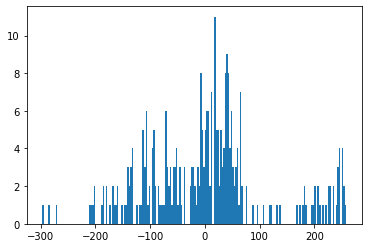

In [121]:
test_angle = angle(y_test)
pred_angle = angle(y_pred)
df = pd.DataFrame({'test_angle': angle(y_test), 'pred_angle': angle(y_pred)})
df['gap'] = df['test_angle'] - df['pred_angle']
plt.hist(x = df['gap'], bins=200);

In [122]:
df.sort_values('gap')

,test_angle,pred_angle,gap
2,18.080540,315.641386,-297.560845
12,25.514713,311.772422,-286.257709
190,87.360904,359.199208,-271.838304
137,84.134706,294.994729,-210.860023
132,82.226326,289.959150,-207.732824
...,...,...,...
227,318.344776,66.799395,251.545380
54,266.115494,13.831715,252.283779
220,333.776791,80.296734,253.480056
246,312.765348,58.484711,254.280636


In [123]:
df['gap'][np.abs(df['gap']) < 200].std()

78.69866946542255